In [ ]:
import sys
if '/disks/cosmodm/vdvuurst' not in sys.path:
    sys.path.append('/disks/cosmodm/vdvuurst')

import numpy as np
import h5py
from matplotlib import pyplot as plt
import os
from importlib import reload
import json
import ONEHALO
from tqdm import tqdm
from functions import *
from onehalo_plotter import plot_distribution_gaussian_mod
import glob
from onehalo_plotter import format_plot
format_plot()
from importlib import reload

In [10]:
np.size([(2,3),(4,5)])

4

46


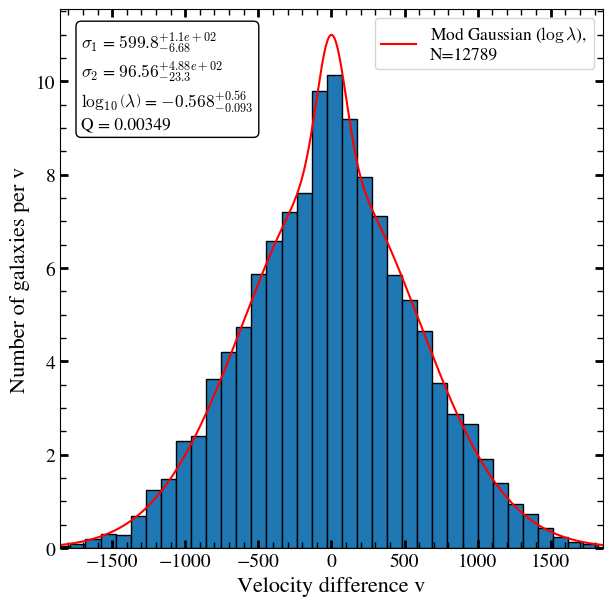

In [6]:
reload(ONEHALO)
massbin = '14.0-14.5'
rbin = '0.10-0.13'

LL_paramfile = f'/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/emcee/M_{massbin}/r_{rbin}_log_lambda.json'
with open(LL_paramfile) as handle:
    params_LL = json.load(handle)

paramfile = f'/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/emcee/M_{massbin}/r_{rbin}.json'
with open(paramfile) as handle:
    params = json.load(handle)

datafile = f'/disks/cosmodm/vdvuurst/data/OneHalo_0.5dex/M_{massbin}/r_{rbin}.hdf5'
with h5py.File(datafile) as handle:
    data = handle['rel_vels'][:].flatten()
    data.sort()

log_lambda_plot = lambda x: plot_distribution_gaussian_mod(mod_gaussian_loglambda, params_LL, data, x, r'Mod Gaussian ($\log \lambda$)', show = True, log_lambda = True)
stnd_plot = lambda x: plot_distribution_gaussian_mod(mod_gaussian, params, data, x, r'Mod Gaussian', show = True)

# log_lambda_plot(100)
print(2 * int(np.cbrt(data.size)))
log_lambda_plot(2 * int(np.cbrt(data.size)))

# from scipy.stats import kstest
# sigma1, sigma2, lambda_ = params_LL['sigma_1'], params_LL['sigma_2'], params_LL['lambda']
# cdf = lambda x: np.cumsum(mod_gaussian_loglambda(x, sigma1, sigma2, lambda_))
# ks_result = kstest(data, cdf)
# print(ks_result)
# plt.figure()
# plt.hist(data, cumulative=True, density=True, bins = 46)
# plt.plot(cdf(data))